<a href="https://colab.research.google.com/github/czuniga76/S4Model_Tests/blob/main/SSSMforcircuits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# S4 implemntation from https://github.com/TariqAHassan/S4Torch.git
# Added Recurrent mode from the Annotated S4 https://srush.github.io/annotated-s4/

In [2]:
from google.colab import drive
drive.mount("/content/MyDrive/")

Drive already mounted at /content/MyDrive/; to attempt to forcibly remount, call drive.mount("/content/MyDrive/", force_remount=True).


In [ ]:
!ls /content/MyDrive/MyDrive/SpiceSimulations/

iout.npy  Vsource.npy


In [3]:
import sys
sys.path.append("/content/MyDrive/MyDrive/S4Tariq/")
import math
import time
from multiprocessing import cpu_count
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import animation, rc
from IPython.display import HTML

In [ ]:
# simulate a buck converter with PySpice and generate input/output data
# Input is voltage across diode. Output is current across load resistor but could also be the voltage.
# PySpice code in https://github.com/PySpice-org/PySpice/blob/master/examples/switched-power-supplies/buck-converter.py
# Buck converter is a DC-DC converter. It takes a higher input voltage and outputs a smaller voltage by using a transistor switch and a 'flywheel' RLC circuit.
# See for example: https://learnabout-electronics.org/PSU/psu31.php
#
#    Vin = 12@u_V
#    Vout = Vout@u_V
#    ratio = Vout / Vin
# Simulate from Vout = 2 to 10 Volts in steps of 0.05 Volts
# Run in separate computer since Ngspcie is needed.


import matplotlib.pyplot as plt

####################################################################################################

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

####################################################################################################

from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *
import time
import numpy as np
####################################################################################################

def simulate_buck_converter(Vout=8):
    libraries_path = ""
    #print(libraries_path)

    spice_library = SpiceLibrary(libraries_path)

    circuit = Circuit('Buck Converter')

    circuit.include(spice_library['1N5822']) # Schottky diode
    circuit.include(spice_library['irf150'])

    # From Microchip WebSeminars - Buck Converter Design Example

    Vin = 12@u_V
    Vout = Vout@u_V
    ratio = Vout / Vin

    Iload = 2@u_A
    Rload = Vout / (.8 * Iload)

    frequency = 400@u_kHz
    period = frequency.period
    duty_cycle = ratio * period

    ripple_current = .3 * Iload # typically 30 %
    ripple_voltage = 50@u_mV

    print('ratio =', ratio)
    print('RLoad =', Rload)
    print('period =', period.canonise())
    print('duty_cycle =', duty_cycle.canonise())
    print('ripple_current =', ripple_current)
    print('frequency ',frequency)
    #r# .. math:
    #r#      U = L \frac{dI}{dt}

    L = (Vin - Vout) * duty_cycle / ripple_current
    RL = 37@u_mΩ

    #r# .. math:
    #r#      dV = dI (ESR + \frac{dt}{C} + \frac{ESL}{dt})

    ESR = 30@u_mΩ
    ESL = 0
    Cout = (ripple_current * duty_cycle) / (ripple_voltage - ripple_current * ESR)

    ripple_current_in = Iload / 2
    ripple_voltage_in = 200@u_mV
    ESR_in = 120@u_mΩ
    Cin = duty_cycle / (ripple_voltage_in / ripple_current_in - ESR_in)

    L = L.canonise()
    Cout = Cout.canonise()
    Cin = Cin.canonise()

    print('L =', L)
    print('Cout =', Cout)
    print('Cint =', Cin)

    circuit.V('in', 'in', circuit.gnd, Vin)
    circuit.C('in', 'in', circuit.gnd, Cin)

    # Fixme: out drop from 12V to 4V
    # circuit.VCS('switch', 'gate', circuit.gnd, 'in', 'source', model='Switch', initial_state='off')
    # circuit.PulseVoltageSource('pulse', 'gate', circuit.gnd, 0@u_V, Vin, duty_cycle, period)
    # circuit.model('Switch', 'SW', ron=1@u_mΩ, roff=10@u_MΩ)

    # Fixme: Vgate => Vout ???
    circuit.X('Q', 'irf150', 'in', 'gate', 'source')
    # circuit.PulseVoltageSource('pulse', 'gate', 'source', 0@u_V, Vin, duty_cycle, period)
    circuit.R('gate', 'gate', 'clock', 1@u_Ω)
    circuit.PulseVoltageSource('pulse', 'clock', circuit.gnd, 0@u_V, 2.*Vin, duty_cycle, period)

    circuit.X('D', '1N5822', circuit.gnd, 'source')
    circuit.L(1, 'source', 1, L)
    circuit.R('L', 1, 'out', RL)
    circuit.C(1, 'out', circuit.gnd, Cout) # , initial_condition=0@u_V
    circuit.R('load', 'out', circuit.gnd, Rload)

    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    ts = time.time()
    end_time = period*200
    analysis = simulator.transient(step_time=period/300, end_time=end_time)
    print(" transient time ",time.time()-ts)
    vsource = analysis['source']
    out = analysis.out
    step = period/300
    N = len(out)
    dt = period/10
    Ns = end_time/dt
    new_step = int(dt/step)
    vsource_r = vsource[0:N:new_step]
    out_r = out[0:N:new_step]
    iout = out_r/Rload
    return vsource_r, iout



Text(0.5, 1.0, 'Schematic of a Buck converter')

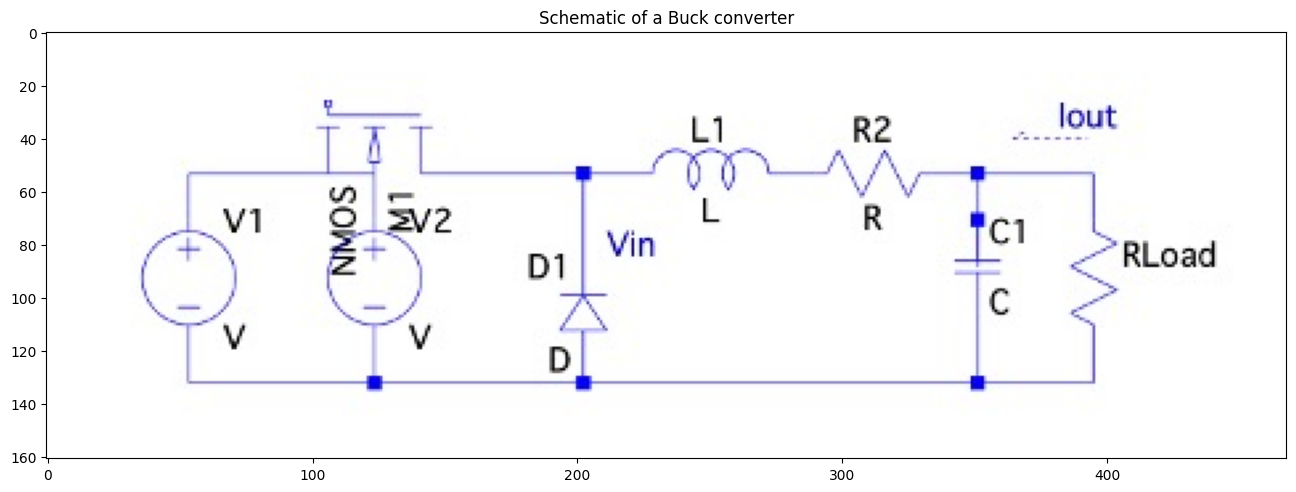

In [4]:
from PIL import Image
direc = "/content/MyDrive/MyDrive/SpiceSimulations/Pictures/"
img = Image.open(direc+"buck_converter.jpg")
fig,ax = plt.subplots(figsize=(16,20))
ax.imshow(img)
plt.title("Schematic of a Buck converter")


In [5]:
direc = "/content/MyDrive/MyDrive/SpiceSimulations/"
X = np.load(direc+"Vsource.npy")
y = np.load(direc+"iout.npy")

from sklearn.model_selection import train_test_split

# Assuming X is your feature matrix and y is your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)
print(X_train.shape,X_val.shape,X_test.shape)

(102, 1700) (26, 1700) (32, 1700)


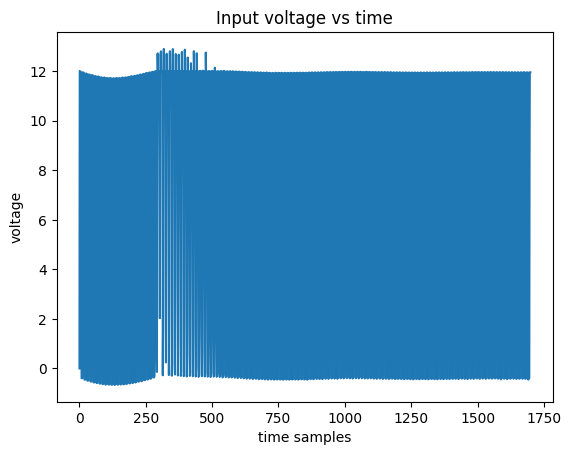

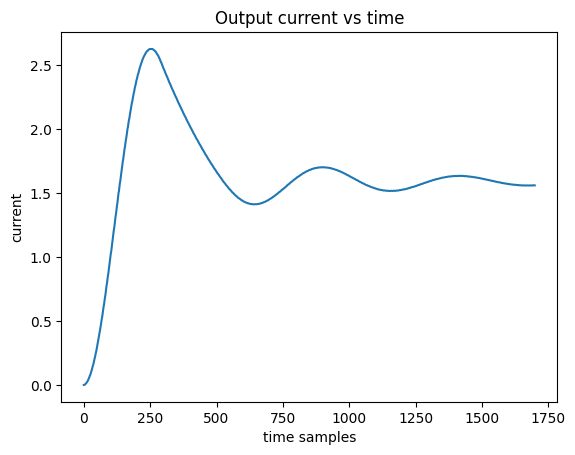

In [6]:

ids = 100
plt.plot(X_train[ids,:])
plt.xlabel("time samples")
plt.ylabel("voltage")
plt.title("Input voltage vs time")
plt.figure()
plt.plot(y_train[ids,:])
plt.xlabel("time samples")
plt.ylabel("current")
plt.title("Output current vs time")
plt.show()

In [7]:
X_train = np.expand_dims(X_train,-1)
X_val = np.expand_dims(X_val,-1)
X_test = np.expand_dims(X_test,-1)
y_train = np.expand_dims(y_train,-1)
y_val = np.expand_dims(y_val,-1)
y_test = np.expand_dims(y_test,-1)

In [8]:
xmax = np.abs(np.max(X_train))
ymax = np.abs(np.max(y_train))
X_train = X_train/xmax
X_val = X_val/xmax
X_test = X_test/xmax
y_train = y_train/ymax
y_val = y_val/ymax
y_test = y_test/ymax


In [9]:
class CircuitDataset(torch.utils.data.Dataset):
    def __init__(self, X_array,y_array):
        self.X_array = X_array.astype(np.float32)
        self.y_array = y_array.astype(np.float32)

    # get sample
    def __getitem__(self, idx):
        X = self.X_array[idx]
        y = self.y_array[idx]
        return  torch.from_numpy(X),torch.from_numpy(y)

    def __len__(self):
        return len(self.X_array)

In [10]:

train_dataset = CircuitDataset(X_train,y_train)
val_dataset = CircuitDataset(X_val,y_val)
test_dataset = CircuitDataset(X_test,y_test)
for X,y in train_dataset:
  print(X.shape,y.shape,X.dtype)
  break
batch_size = 4

train_dataloader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
)
val_dataloader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=True,
)
test_dataloader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=batch_size,
            shuffle=True,
)

print(" test ")
for X,y in test_dataloader:
  print(X.shape)


torch.Size([1700, 1]) torch.Size([1700, 1]) torch.float32
 test 
torch.Size([4, 1700, 1])
torch.Size([4, 1700, 1])
torch.Size([4, 1700, 1])
torch.Size([4, 1700, 1])
torch.Size([4, 1700, 1])
torch.Size([4, 1700, 1])
torch.Size([4, 1700, 1])
torch.Size([4, 1700, 1])


In [43]:
import importlib
#from s4torch import S4Model
#import s4torch.model as S4Model
import s4torch
importlib.reload(s4torch)
from s4torch import S4Model


class S4MLPModel(nn.Module):
  def __init__(self,d_input: int, d_model: int, d_output: int, n_blocks: int, n: int, Dt: float, l_max: int):
    super().__init__()
    self.base_model = S4Model(d_model,d_model=d_model,d_output=d_model,n_blocks=n_blocks,n=n,Dt=Dt,l_max=l_max,norm_type=None,collapse=False)
    self.encoder1 = nn.Linear(d_input,d_model)
    self.encoder2 = nn.Linear(d_model,d_model)
    self.activation = nn.LeakyReLU()
    self.decoder1 = nn.Linear(d_model,d_model)
    self.decoder2 = nn.Linear(d_model,d_output)


  def forward(self,x):
    x = self.encoder1(x)
    x = self.activation(x)
    x = self.encoder2(x)

    #print(" x ",x.shape)
    x = self.base_model(x)
    #print(" after s4 ",x.shape)
    x = self.decoder1(x)
    x = self.activation(x)
    x = self.decoder2(x)
    return x

N = 8   # inner dimension of S4 model. In S4 literature, usually higher but problem has low dimensionality ( 1 inductor,  1 capacitor)
d_input = 1
d_model = 1
d_output = 1
n_blocks = 1    # simple problem so don't expect to need deep models
seq_len = 1700
frequency = 400000
P = 1/frequency
Dt =  0.001 # P/10      # too small seems to cause oscillations and a collapse?

u = torch.randn(1, seq_len, d_input)

# simple model
# Removed activation in S4Model to make a linear model
s4model = S4Model(        # TODO fix dt
    d_input,
    d_model=d_model,
    d_output=d_output,
    n_blocks=n_blocks,
    n=N,
    Dt=Dt,
    l_max=seq_len,
    norm_type=None,
    collapse=False,  # average predictions over time prior to decoding
)


#s4model = S4MLPModel(        # TODO fix dt
#    d_input,
#    d_model=d_model,
#    d_output=d_output,
#    n_blocks=n_blocks,
#    n=N,
#    Dt=Dt,
#    l_max=seq_len,
#    #norm_type=None,
#    #collapse=False,  # average predictions over time prior to decoding
#)

for X,y in train_dataloader:
  print(" X ,y ",X.shape,y.shape)
  pred = s4model(X)
  print(" pred ",pred.shape)
  break

 X ,y  torch.Size([4, 1700, 1]) torch.Size([4, 1700, 1])
 pred  torch.Size([4, 1700, 1])


In [12]:
def train_loop(dataloader, model, loss_fn, optimizer,device,batch_size=16):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    model = model.to(device)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)
        pred = model(X)


        #print(" y , pred ",y.shape,pred.shape)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn, device):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    model = model.to(device)
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            #print(" y , pred ",y.shape,pred.shape)
            test_loss += loss_fn(pred, y).item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error Avg loss: {test_loss:>8f} \n")

In [44]:
loss_fn = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(s4model.parameters(), lr=1e-3)

epochs = 200  # simple training loop


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, s4model, loss_fn, optimizer, device)
    print(" validating")   # TODO add early stopping
    test_loop(val_dataloader, s4model, loss_fn, device)

print("Done!")

Epoch 1
-------------------------------
loss: 0.977403  [    4/  102]
 validating
Test Error Avg loss: 0.728937 

Epoch 2
-------------------------------
loss: 0.733412  [    4/  102]
 validating
Test Error Avg loss: 0.526458 

Epoch 3
-------------------------------
loss: 0.554038  [    4/  102]
 validating
Test Error Avg loss: 0.337446 

Epoch 4
-------------------------------
loss: 0.321526  [    4/  102]
 validating
Test Error Avg loss: 0.183512 

Epoch 5
-------------------------------
loss: 0.188646  [    4/  102]
 validating
Test Error Avg loss: 0.088665 

Epoch 6
-------------------------------
loss: 0.086495  [    4/  102]
 validating
Test Error Avg loss: 0.058390 

Epoch 7
-------------------------------
loss: 0.062357  [    4/  102]
 validating
Test Error Avg loss: 0.053480 

Epoch 8
-------------------------------
loss: 0.058196  [    4/  102]
 validating
Test Error Avg loss: 0.048259 

Epoch 9
-------------------------------
loss: 0.049689  [    4/  102]
 validating
Test E

In [14]:
def eval_loop(dataloader, model, loss_fn, device):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    model = model.to(device)
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for i,(X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)
            #pred = model(to_sequence(X))
            pred = model(X)
            #print(" y , pred ",y.shape,pred.shape)
            test_loss += loss_fn(pred, y).item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            print(pred.shape)
            pred = pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()
            plt.plot(y[0,:,0])
            #plt.figure()
            plt.plot(pred[0,:,0])
            plt.legend(["current","pred_current"])
            plt.figure()
            if i > 4:
                break

    test_loss /= num_batches
    correct /= size
    print(f" Avg loss: {test_loss:>8f} \n")

In [27]:
#torch.save(s4model,direc+"s4MLP_bucket.mod")


torch.Size([4, 1700, 1])
torch.Size([4, 1700, 1])
torch.Size([4, 1700, 1])
torch.Size([4, 1700, 1])
torch.Size([4, 1700, 1])
torch.Size([4, 1700, 1])
 Avg loss: 0.003798 



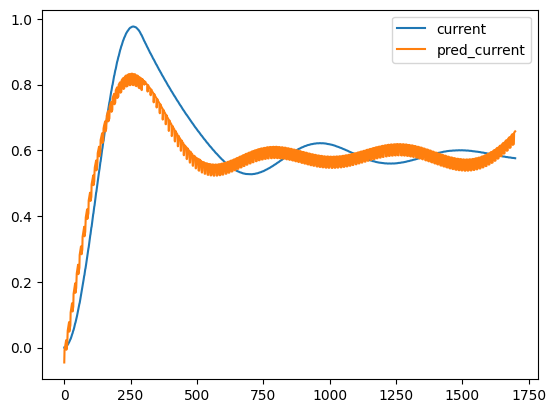

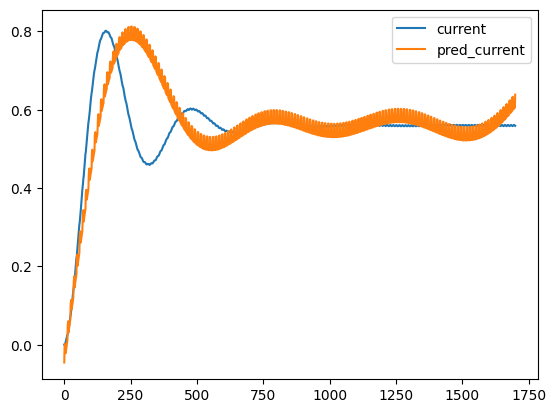

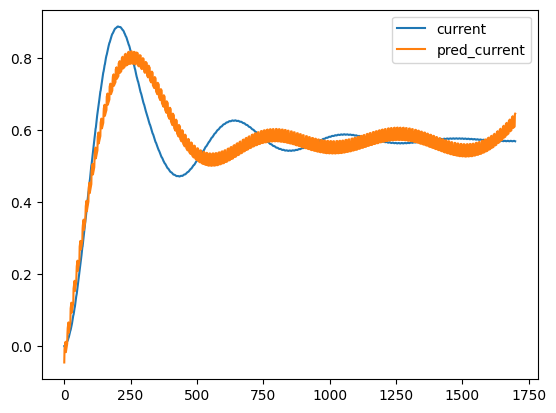

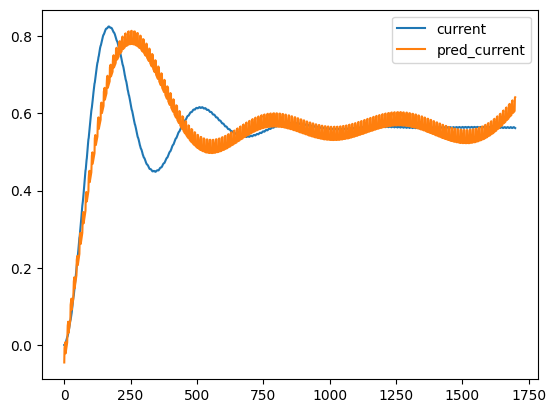

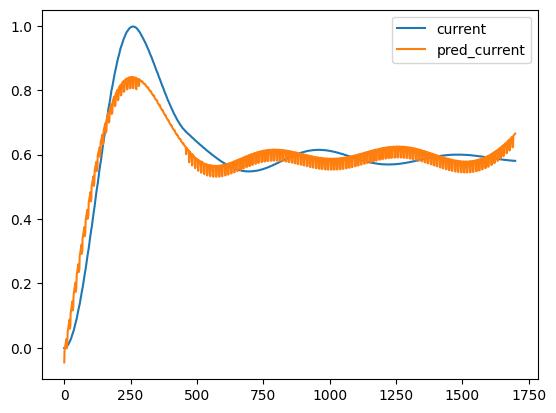

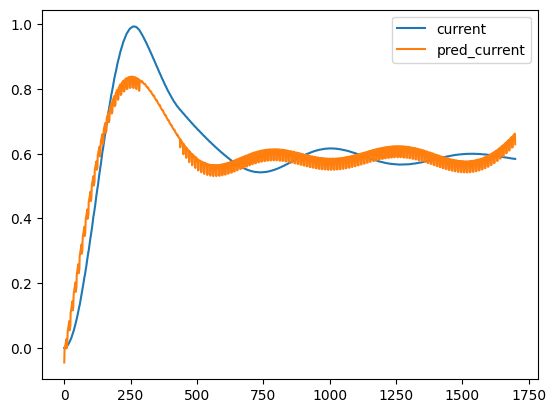

<Figure size 640x480 with 0 Axes>

In [45]:
loss_fn = nn.MSELoss()
eval_loop(test_dataloader, s4model, loss_fn, device)

In [38]:
def eval_loop2(dataloader, model, loss_fn, device):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    model = model.to(device)
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for i,(X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)
            #pred = model(to_sequence(X))
            X = X[:1,:,:]
            print("input ", X.shape)
            ts = time.time()
            pred = model(X)
            print(" inference time, conv ",time.time()-ts)
            #print(" y , pred ",y.shape,pred.shape)
            #test_loss += loss_fn(pred, y).item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            print(pred.shape)
            break

eval_loop2(test_dataloader, s4model, loss_fn, device)

input  torch.Size([1, 1700, 1])
 inference time, conv  0.005138874053955078
torch.Size([1, 1700, 1])


In [ ]:
# test Mamba model
#! git clone https://github.com/alxndrTL/mamba.py.git /content/MyDrive/MyDrive/Mamba

/content/MyDrive/MyDrive/SpiceSimulations/
Cloning into '/content/MyDrive/MyDrive/Mamba'...
remote: Enumerating objects: 1016, done.
remote: Counting objects: 100% (194/194), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 1016 (delta 166), reused 134 (delta 134), pack-reused 822 (from 2)
Receiving objects: 100% (1016/1016), 10.09 MiB | 13.46 MiB/s, done.
Resolving deltas: 100% (609/609), done.


In [ ]:
sys.path.append("/content/MyDrive/MyDrive/Mamba/")